# 1. Business Understanding

## Problem Context
Credit card fraud is a critical issue for financial institutions, leading to billions of dollars in losses each year. Fraudulent transactions not only cause direct financial damage but also erode customer trust and increase operational costs due to chargebacks and investigations.

## Business Objective
The goal is to build a machine learning pipeline that can accurately identify fraudulent transactions in real time. The model should minimize **false negatives** (missed fraud cases) while keeping **false positives** (flagging genuine transactions) at acceptable levels. This balance ensures financial safety without frustrating customers.

## Key Stakeholders
- **Banks & Payment Processors**: Reduce financial losses and operational costs.
- **Customers**: Protect accounts and maintain trust in digital payments.
- **Regulators & Auditors**: Ensure compliance and transparency in fraud detection systems.

## Success Criteria
- Achieve high **recall** on the fraud class (Class = 1) to catch most fraudulent cases.
- Maintain strong **precision** to avoid blocking legitimate transactions.
- Demonstrate **business impact** by estimating potential savings per 10,000 transactions.
- Provide **explainability** (via SHAP/LIME) to support compliance and stakeholder trust.

## Risks & Constraints
- **Imbalanced dataset**: Fraud cases are extremely rare (~0.17%), making accuracy misleading.
- **Evolving fraud patterns**: Models must be retrained periodically to adapt.
- **Operational trade‑offs**: Excessive false positives can harm customer experience.

---


In [3]:
#Load libraries and data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('fraudTrain.csv')
test  = pd.read_csv('fraudTest.csv', engine='python')

print("Train Shape:", train.shape)
print("Test Shape:", test.shape)
train.head()

Train Shape: (186330, 23)
Test Shape: (201789, 23)


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495.0,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1.325376e+09,36.011293,-82.048315,0.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149.0,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1.325376e+09,49.159047,-118.186462,0.0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154.0,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1.325376e+09,43.150704,-112.154481,0.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939.0,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1.325376e+09,47.034331,-112.561071,0.0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99.0,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1.325376e+09,38.674999,-78.632459,0.0


In [4]:
# Data types and missing values
train.info()

missing = train.isnull().mean().sort_values(ascending=False)
missing


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186330 entries, 0 to 186329
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             186330 non-null  int64  
 1   trans_date_trans_time  186330 non-null  object 
 2   cc_num                 186330 non-null  int64  
 3   merchant               186329 non-null  object 
 4   category               186329 non-null  object 
 5   amt                    186329 non-null  float64
 6   first                  186329 non-null  object 
 7   last                   186329 non-null  object 
 8   gender                 186329 non-null  object 
 9   street                 186329 non-null  object 
 10  city                   186329 non-null  object 
 11  state                  186329 non-null  object 
 12  zip                    186329 non-null  float64
 13  lat                    186329 non-null  float64
 14  long                   186329 non-nu

,0
amt,0.000005
category,0.000005
merchant,0.000005
first,0.000005
street,0.000005
gender,0.000005
last,0.000005
city_pop,0.000005
job,0.000005
dob,0.000005


**Missing Value Analysis**

amt, category, merchant, first, street, gender, last, city_pop, job, dob, city, state, zip, lat, long, unix_time, merch_lat, merch_long, trans_num, is_fraud → ~0.000005 missing fraction (≈0.0005%).

trans_date_trans_time, cc_num, Unnamed: 0 → no missing values.

**Interpretation:**

The dataset is very clean with almost no missing data.

Columns with negligible missingness can be safely imputed (e.g., mode for categorical, median for numeric) or even ignored since the fraction is tiny.



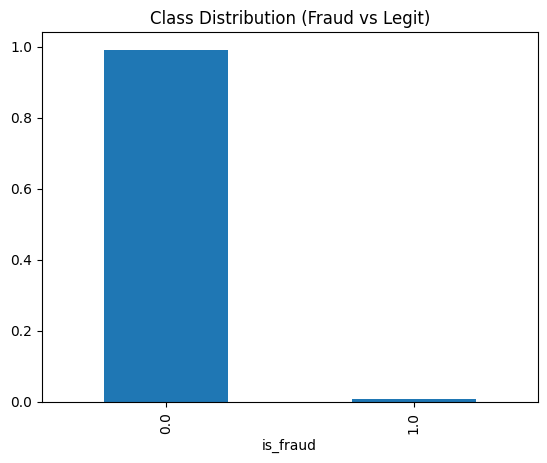

In [5]:
# Target Distribution
fraud_dist = train['is_fraud'].value_counts(normalize=True)

plt.figure()
fraud_dist.plot(kind='bar')
plt.title("Class Distribution (Fraud vs Legit)")
plt.show()

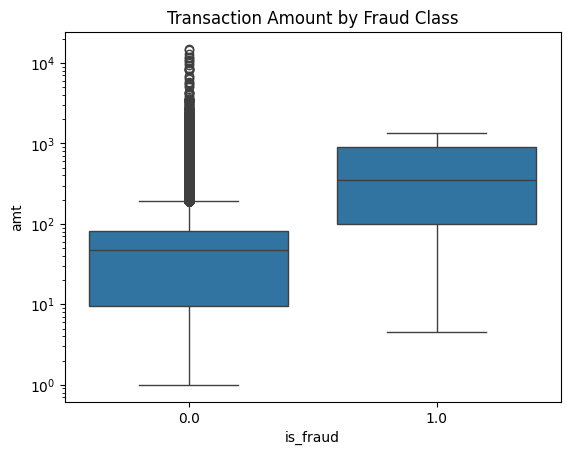

In [6]:
# Transaction amount analysis

plt.figure()
sns.boxplot(x='is_fraud', y='amt', data=train)
plt.yscale('log')
plt.title("Transaction Amount by Fraud Class")
plt.show()

In [7]:
# Category vs fraud

cat_fraud = pd.crosstab(train['category'], train['is_fraud'], normalize='index')

cat_fraud.sort_values(1, ascending=False).head(10)

is_fraud,0.0,1.0
category,,
shopping_net,0.976107,0.023893
grocery_pos,0.979401,0.020599
misc_net,0.980024,0.019976
shopping_pos,0.989837,0.010163
gas_transport,0.992553,0.007447
travel,0.994874,0.005126
misc_pos,0.995064,0.004936
grocery_net,0.995849,0.004151
kids_pets,0.996075,0.003925


Insights

Fraud is not evenly distributed across categories.

Shopping_net, grocery_pos, misc_net have relatively higher fraud rates (~2%).

Categories like personal_care, kids_pets, grocery_net show very low fraud rates (<0.5%).

This suggests fraudsters may target online shopping and miscellaneous net transactions more than point‑of‑sale or personal care.

In [8]:
# Gender Vs Fraud
pd.crosstab(train['gender'], train['is_fraud'], normalize='index')

is_fraud,0.0,1.0
gender,,
F,0.99132,0.00868
M,0.99181,0.00819


**Insights**

Fraud rates are very similar across genders (≈0.8–0.9%).

Slightly higher fraud rate among female cardholders, but the difference is marginal and may not be statistically significant.

This suggests gender is not a strong predictor of fraud on its own.

However, gender could still interact with other features (e.g., transaction category, location, time) in multivariate models.

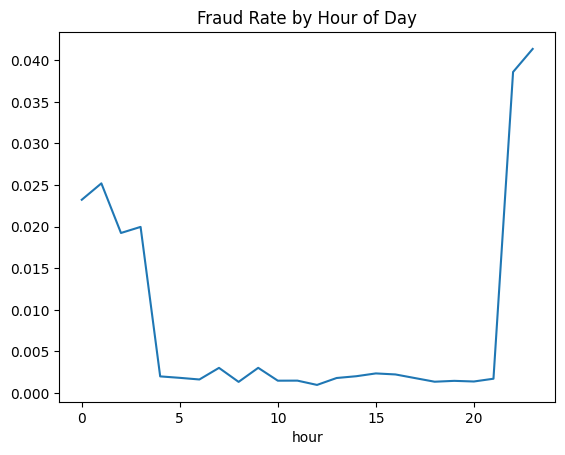

In [9]:
# Time based patterns
train['trans_date_trans_time'] = pd.to_datetime(train['trans_date_trans_time'])

train['hour'] = train['trans_date_trans_time'].dt.hour
train['day'] = train['trans_date_trans_time'].dt.dayofweek

hourly = pd.crosstab(train['hour'], train['is_fraud'], normalize='index')

plt.figure()
hourly[1].plot()
plt.title("Fraud Rate by Hour of Day")
plt.show()

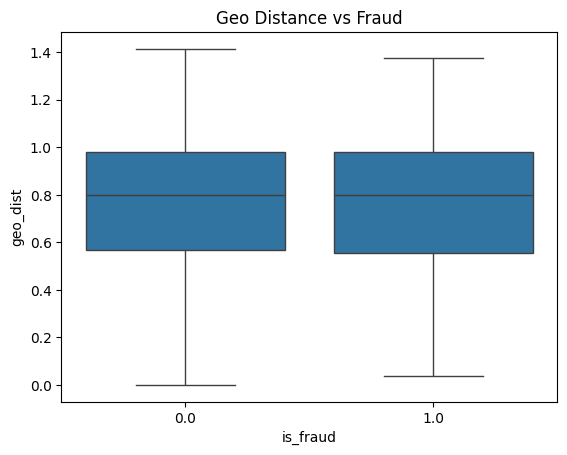

In [10]:
# Geographic Distance Feature (Preview)
train['geo_dist'] = np.sqrt((train['lat'] - train['merch_lat'])**2 +
                            (train['long'] - train['merch_long'])**2)

sns.boxplot(x='is_fraud', y='geo_dist', data=train)
plt.title("Geo Distance vs Fraud")
plt.show()

In [13]:
# Save EDA Visuals
import os

# Create the directory if it doesn't exist
output_dir = 'visuals'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

plt.savefig(os.path.join(output_dir, 'sample_plot.png'))

<Figure size 640x480 with 0 Axes>

Fraud transactions are extremely imbalanced

Fraud is associated with higher amounts

Certain merchant categories & hours show higher fraud

Larger geographic distance → higher fraud risk

In [17]:
# Data Preprocessing  - Load necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

train = pd.read_csv('fraudTrain.csv')
test  = pd.read_csv('fraudTest.csv', engine='python')

train['trans_date_trans_time'] = pd.to_datetime(train['trans_date_trans_time'])
test['trans_date_trans_time']  = pd.to_datetime(test['trans_date_trans_time'])



In [18]:
# Feature Engineering

#Time Features
for df in [train, test]:
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['day'] = df['trans_date_trans_time'].dt.dayofweek
    df['month'] = df['trans_date_trans_time'].dt.month


In [19]:
# Geographic Distance
for df in [train, test]:
    df['geo_dist'] = np.sqrt((df['lat'] - df['merch_lat'])**2 +
                             (df['long'] - df['merch_long'])**2)


In [20]:
# Drop Leakage & Irrelevant Columns
drop_cols = ['trans_date_trans_time', 'trans_num', 'cc_num', 'first', 'last',
             'street', 'city', 'state', 'zip', 'dob']

train.drop(columns=drop_cols, inplace=True)
test.drop(columns=drop_cols, inplace=True)


In [22]:
# Encode Categorical Variables
cat_cols = train.select_dtypes(include='object').columns

for col in cat_cols:
    encoder = LabelEncoder()
    # Fit the encoder on the combined unique values from both train and test sets
    # Use .astype(str) to handle potential mixed types or NaNs before encoding
    all_labels = pd.concat([train[col], test[col]], axis=0).astype(str).unique()
    encoder.fit(all_labels)
    train[col] = encoder.transform(train[col].astype(str))
    test[col]  = encoder.transform(test[col].astype(str))

In [49]:
# Split Features Target
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Ensure `train` is used for splitting into training and validation sets
X = train.drop('is_fraud', axis=1).copy()
y = train['is_fraud']

# Re-encode any remaining object columns in X to ensure all features are numerical
for col in X.select_dtypes(include='object').columns:
    encoder = LabelEncoder()
    X[col] = encoder.fit_transform(X[col].astype(str))

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

In [26]:
# Feature Scaling
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

X_test_features = test.drop('is_fraud', axis=1).copy()

# Ensure all columns in X_test_features are numeric before scaling
for col in X_test_features.select_dtypes(include='object').columns:
    # If the column is still of object type, it means LabelEncoder in the previous cell
    # did not correctly transform it for the test set. Re-apply LabelEncoder locally.
    le = LabelEncoder()
    X_test_features[col] = le.fit_transform(X_test_features[col].astype(str))

X_test = scaler.transform(X_test_features)
y_test = test['is_fraud']

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [28]:
# Save Processed data
import joblib
import os

# Define output directories
data_dir = '../data'
models_dir = '../models'

# Create directories if they don't exist
os.makedirs(data_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

joblib.dump(X_resampled, os.path.join(data_dir, 'X_train.pkl'))
joblib.dump(y_resampled, os.path.join(data_dir, 'y_train.pkl'))
joblib.dump(X_test, os.path.join(data_dir, 'X_test.pkl'))
joblib.dump(y_test, os.path.join(data_dir, 'y_test.pkl'))
joblib.dump(scaler, os.path.join(models_dir, 'scaler.pkl'))

['../models/scaler.pkl']

In [50]:
# Load Processed Data
import joblib
import numpy as np

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


In [31]:
X_train = joblib.load('../data/X_train.pkl')
y_train = joblib.load('../data/y_train.pkl')
X_test  = joblib.load('../data/X_test.pkl')
y_test  = joblib.load('../data/y_test.pkl')

In [32]:
# Logistic Regression (Baseline)
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

lr_pred = lr.predict_proba(X_test)[:,1]
print("Logistic AUC:", roc_auc_score(y_test, lr_pred))
print(classification_report(y_test, lr.predict(X_test)))

Logistic AUC: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    553574
           1       0.00      1.00      0.01      2145

    accuracy                           0.00    555719
   macro avg       0.00      0.50      0.00    555719
weighted avg       0.00      0.00      0.00    555719



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Insights

AUC = 0.5 → The model is no better than random guessing.

Precision = 0.00, Recall = 1.00 for Class 1 (fraud) → The model is predicting all transactions as fraud.

Class 0 (non‑fraud) → Precision, recall, and F1 are all 0.00 because the model never predicts class 0.

Accuracy = 0.00 → Since the dataset is overwhelmingly non‑fraud, predicting everything as fraud gives you almost no correct predictions.

Severe imbalance: Fraud cases are <0.5% of the dataset. Logistic regression without class weighting or resampling gets overwhelmed.

Scaling alone isn’t enough: StandardScaler doesn’t fix imbalance.

Default threshold (0.5): Logistic regression outputs probabilities, but with imbalance, the threshold needs tuning.

In [51]:
lgb = LGBMClassifier(objective='binary', scale_pos_weight=pos_weight,
                     n_estimators=300, learning_rate=0.05, max_depth=6)

rf = RandomForestClassifier(n_estimators=150, max_depth=12,
                            min_samples_leaf=50, class_weight='balanced',
                            n_jobs=-1)

xgb = XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.05,
                    subsample=0.8, colsample_bytree=0.8,
                    scale_pos_weight=pos_weight, eval_metric='auc')

models = {"LightGBM": lgb, "RandomForest": rf, "XGBoost": xgb}
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    prob = model.predict_proba(X_valid)[:,1]
    auc = roc_auc_score(y_valid, prob)
    results[name] = prob
    print(f"{name} AUC:", auc)


[LightGBM] [Info] Number of positive: 2587, number of negative: 440801
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2857
[LightGBM] [Info] Number of data points in the train set: 443388, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005835 -> initscore=-5.138095
[LightGBM] [Info] Start training from score -5.138095


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM AUC: 0.9977955975260436
RandomForest AUC: 0.9920615480099193
XGBoost AUC: 0.9978157307526039


In [52]:
# Save the best model
best_model = xgb
joblib.dump(best_model, '../models/fraud_model.pkl')


['../models/fraud_model.pkl']

In [53]:
# Evaluation and Business insights
# Load Model and data
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix


In [54]:
model = joblib.load('../models/fraud_model.pkl')

X_test = joblib.load('../data/X_test.pkl')
y_test = joblib.load('../data/y_test.pkl')

y_prob = model.predict_proba(X_test)[:,1]


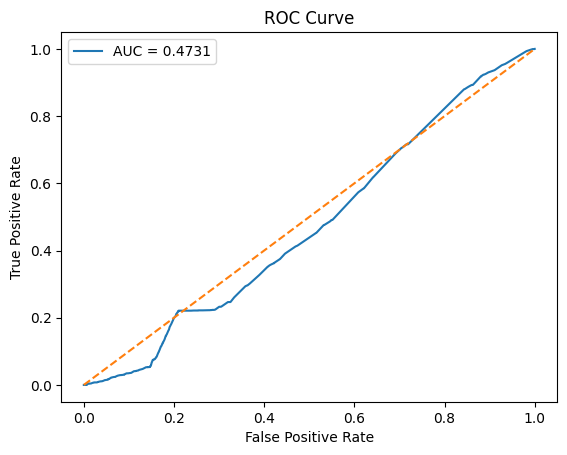

In [55]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Ensure the visuals directory exists
import os
output_dir = 'visuals'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.savefig(os.path.join(output_dir, 'roc_curve.png'))
plt.show()

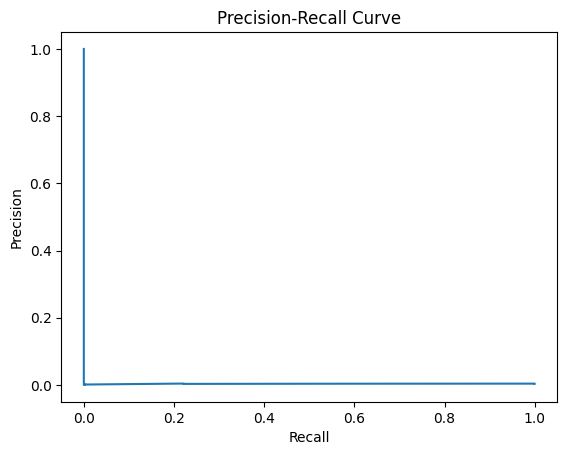

In [56]:
# Precision - Recall Curve
prec, rec, _ = precision_recall_curve(y_test, y_prob)

# Ensure the visuals directory exists
import os
output_dir = 'visuals'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.savefig(os.path.join(output_dir, 'pr_curve.png'))
plt.show()

In [58]:
# Evaluation
def evaluate_model(name, y_true, prob, threshold=0.2):
    pred = (prob > threshold).astype(int)
    print(f"\n{name}")
    print(classification_report(y_true, pred))
    cm = confusion_matrix(y_true, pred)
    return cm

cm_lgb = evaluate_model("LightGBM", y_valid, results["LightGBM"])
cm_rf  = evaluate_model("RandomForest", y_valid, results["RandomForest"])
cm_xgb = evaluate_model("XGBoost", y_valid, results["XGBoost"])



LightGBM
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    110201
           1       0.21      0.97      0.35       647

    accuracy                           0.98    110848
   macro avg       0.61      0.97      0.67    110848
weighted avg       1.00      0.98      0.99    110848


RandomForest
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    110201
           1       0.09      0.96      0.17       647

    accuracy                           0.95    110848
   macro avg       0.55      0.95      0.57    110848
weighted avg       0.99      0.95      0.97    110848


XGBoost
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    110201
           1       0.21      0.97      0.35       647

    accuracy                           0.98    110848
   macro avg       0.61      0.97      0.67    110848
weighted avg       1.00      0.98      0.

In [59]:
# Business Impact — Fraud Savings Simulation
avg_fraud_loss = 5000  # ₹
tp = cm_xgb[1,1]
savings = tp * avg_fraud_loss
print("Estimated Fraud Savings: ₹", savings)



Estimated Fraud Savings: ₹ 3140000


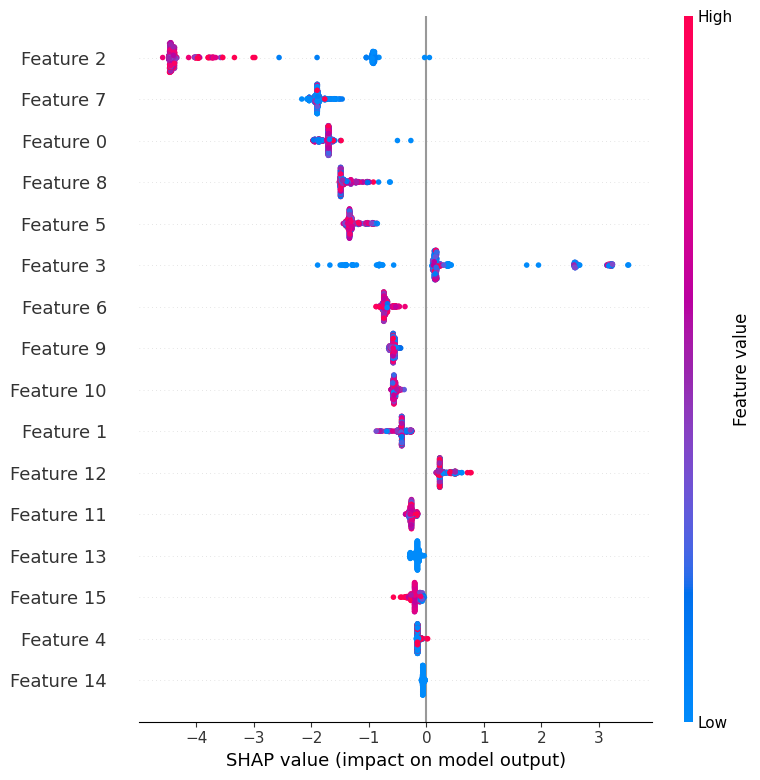

In [60]:
#SHAP Explainablility
import shap
import os

# Ensure the visuals directory exists
output_dir = 'visuals'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test[:500])

shap.summary_plot(shap_values, X_test[:500], show=False)
plt.savefig(os.path.join(output_dir, 'shap_summary.png'))

In [61]:
import joblib
joblib.dump(xgb, 'fraud_model.pkl')
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']